## Case: New Learner

### Setup

This notebook will illustrate the process of getting recommendations for a first-time learner. First we import the required libraries and read in the data.

In [70]:
# Necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#pip install yellowbrick

In [71]:
# Read in data
# Student info table
raw_url = 'https://drive.google.com/file/d/1sQ4OZAzxUi5zX_xjDz-b4RAJ6imPuczq/view?usp=sharing'
url ='https://drive.google.com/uc?id=' + raw_url.split('/')[-2]

std_df = pd.read_csv(url, index_col = 0)

# Activities table
raw_url = 'https://drive.google.com/file/d/1Z_IW3O2ckA1-w0tWEZMS7Bmd5dBIglNO/view?usp=sharing'
url ='https://drive.google.com/uc?id=' + raw_url.split('/')[-2]

act_df = pd.read_csv(url, index_col = 0)

# Courseplan table
raw_url = 'https://drive.google.com/file/d/1NEFGcm4hG08UZ8S_W1kDzYXZ_rCu0USe/view?usp=sharing'
url ='https://drive.google.com/uc?id=' + raw_url.split('/')[-2]

courseplan_df = pd.read_csv(url, index_col = 0)

# Student activity table
raw_url = 'https://drive.google.com/file/d/1ai080vOvAM3a82AArVRA86QwwWb5I5rx/view?usp=sharing'
url ='https://drive.google.com/uc?id=' + raw_url.split('/')[-2]

std_act_df = pd.read_csv(url, index_col = 0)

# Student performance table
raw_url = 'https://drive.google.com/file/d/1dKR6tH0DcBXZXcSycUl38wfqlwRQzALY/view?usp=sharing'
url ='https://drive.google.com/uc?id=' + raw_url.split('/')[-2]

std_performance_df = pd.read_csv(url, index_col = 0)

### Overview of what the tables look like

In [72]:
std_df.head()

,User_ID,Gender,User_Name,Birthday,Age,Literate,Learning_Rate,Country_of_Birth,Country_of_Residence,Translanguage_Level,Cultural_Heritage,Main_Language,Learning_Language,Learning_Profile
0,0,F,Norma Fisher,2016-04-12,5,In_Progress,Fast,Brazil,US,1,"['Brazil', 'Mexico']",Spanish,Portuguese,HL
1,1,F,Kayla Sullivan,2015-03-31,6,Not_Started,Slow,Denmark,Mexico,1,"['Canada', 'US', 'Australia']",Spanish,French,HL
2,2,F,Elizabeth Woods,2015-03-23,6,In_Progress,Slow,Denmark,UK,1,"['Canada', 'Denmark']",English,Danish,HL
3,3,F,Susan Wagner,2016-11-18,4,Complete,Fast,US,Denmark,1,"['Denmark', 'Canada', 'Canada']",Danish,English,HL
4,4,M,Peter Montgomery,2017-11-06,3,In_Progress,Fast,Spain,Portugal,1,['Portugal'],Portuguese,Portuguese,IL


In [73]:
act_df.head(5)

,Activity_ID,Activity_Name,Activity_Type,Hits,Level,Activity_Content,GameType,Words_List,Ages_2yo,Ages_3yo,Ages_4yo,Ages_5yo,Ages_6yo,Cultures_None,Cultures_Brazil,Cultures_US,Cultures_UK,Cultures_Denmark,Cultures_Spain,Cultures_Mexico,Cultures_Canada,Cultures_Portugal,Cultures_Australia,Cultures_France,Cultures_Italy,Cultures_Germany
0,farm-yasmin-flashcards-1,Easy Flashcards - farm animals,standard,5,easy,farm-animals,flashcards,"['horse', 'pig', 'cow', 'hen', 'sheep', 'roost...",1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,farm-yasmin-flashcards-2,Medium Flashcards - farm animals,standard,6,medium,farm-animals,flashcards,"['horse', 'pig', 'cow', 'hen', 'sheep', 'roost...",1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,farm-yasmin-flashcards-3,Difficult Flashcards - farm animals,standard,7,difficult,farm-animals,flashcards,"['horse', 'pig', 'cow', 'hen', 'sheep', 'roost...",1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,pets-yasmin-flashcards-1,Easy Flashcards - pets,standard,5,easy,pets,flashcards,"['birdie', 'cat', 'dog', 'fish', 'parrot', 'ki...",1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,pets-yasmin-flashcards-2,Medium Flashcards - pets,standard,6,medium,pets,flashcards,"['birdie', 'cat', 'dog', 'fish', 'parrot', 'ki...",1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [74]:
std_act_df.head(5)

,Stamp,Activity_ID,User_ID,Hits,Misses,Max_Hits,GamePlayTime,Scores,Translanguage_Level_1,Translanguage_Level_2,Words,Course_ID,Usefulness
0,2021-09-27 03:19:31,easter-colors-game-2,0,8,7,8,279.483906,64.299357,1,3,"['orange', 'purple', 'purple', 'brown', 'black...",0_0,26.500116
1,2021-09-30 22:21:26,easter-colors-game-2,0,8,5,8,287.051023,71.992602,1,3,"['purple', 'white', 'black', 'white', 'blue', ...",0_0,21.884169
2,2021-10-03 00:54:19,pirate-all-puzzle-1,0,8,4,8,275.561071,76.455156,1,2,"['two', 'eight', 'two', 'two', 'four', 'seven'...",0_0,19.206637
3,2021-10-04 08:03:06,values-all-book-20,0,1,0,1,270.096018,84.479003,1,1,['stressed'],0_0,14.392328
4,2021-10-06 21:28:46,values-all-book-22,0,1,0,1,274.757235,84.414754,1,1,['sad'],0_0,14.430878


In [75]:
# Clustering on std info table
std_table = std_df[['Gender', 'Literate', 'Country_of_Birth', 'Country_of_Residence', 'Main_Language', 'Learning_Language', 'Learning_Profile']]
std_table.head()

,Gender,Literate,Country_of_Birth,Country_of_Residence,Main_Language,Learning_Language,Learning_Profile
0,F,In_Progress,Brazil,US,Spanish,Portuguese,HL
1,F,Not_Started,Denmark,Mexico,Spanish,French,HL
2,F,In_Progress,Denmark,UK,English,Danish,HL
3,F,Complete,US,Denmark,Danish,English,HL
4,M,In_Progress,Spain,Portugal,Portuguese,Portuguese,IL


### Data Preprocessing

We need to encode the categorical values so that it can be analysed using ML models.

In [76]:
Categorical_vals = ['Gender', 'Literate', 'Country_of_Birth', 'Country_of_Residence', 'Main_Language', 'Learning_Language', 'Learning_Profile']

from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()

std_transformed = onehotencoder.fit_transform(std_table[Categorical_vals])
std_transformed = std_transformed.toarray()

Since the encoded data is very sparse, we will use sparse PCA to reduce the dimensionality of the data. This would usually improve the modelling stage.

In [77]:
from sklearn.decomposition import SparsePCA

transformer = SparsePCA(n_components = 3, random_state = 0)
std_reduced = transformer.fit_transform(std_transformed)

array([[ 0.68330319,  0.22267534, -0.61679238],
       [ 0.68330319, -0.20849636, -0.61679238],
       [ 0.68330319, -0.54448974, -0.61679238],
       [ 0.68330319,  0.67474312, -0.61679238],
       [-0.71690826,  0.26634941,  0.78329171]])

What the data looks like after being processed:


Note: The components present are features derived from the sparse data earlier.

In [94]:
std_reduced =  pd.DataFrame(std_reduced, columns = ['Component1', 'Component2', 'Component3'])
std_reduced.head(5)

,Component1,Component2,Component3
0,0.683303,0.222675,-0.616792
1,0.683303,-0.208496,-0.616792
2,0.683303,-0.544490,-0.616792
3,0.683303,0.674743,-0.616792
4,-0.716908,0.266349,0.783292


### Clustering of data

We will proceed with an unsupervised learning approach to find 'clusters' or groups among users. Users in the same cluster/group will have similar characteristics, and hence might find similar courses useful.

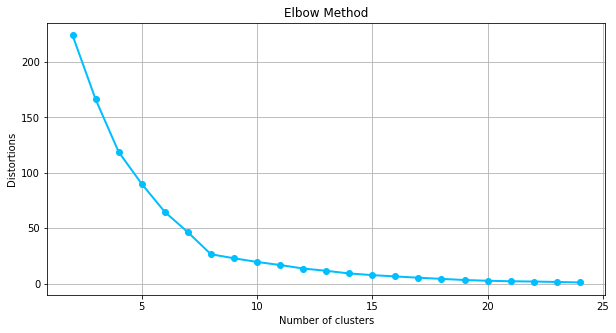

In [79]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

distortions = []

for i in range(2,25):
    kmeans = KMeans(n_clusters = i, random_state = 0).fit(std_reduced)
    cluster_labels = kmeans.fit_predict(std_reduced)

    distortions.append(kmeans.inertia_)


plt.figure(figsize=(10,5))
plt.plot(np.arange(2,25), distortions, marker = 'o', lw = 2, color = 'deepskyblue')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Distortions')
plt.grid()
plt.show()

Using the K-Means clustering & elbow method, we choose the number of clusters where there appears to be an 'elbow', in this case where the number of clusters equal 8.

In [80]:
kmeans = KMeans(n_clusters = 8, random_state = 0)
clusters = kmeans.fit_predict(std_reduced)

std_reduced['Cluster'] = clusters
std_df['Cluster'] = clusters

We will then add the clusters information to the original student info data.

In [81]:
std_df.head(5)

,User_ID,Gender,User_Name,Birthday,Age,Literate,Learning_Rate,Country_of_Birth,Country_of_Residence,Translanguage_Level,Cultural_Heritage,Main_Language,Learning_Language,Learning_Profile,Cluster
0,0,F,Norma Fisher,2016-04-12,5,In_Progress,Fast,Brazil,US,1,"['Brazil', 'Mexico']",Spanish,Portuguese,HL,0
1,1,F,Kayla Sullivan,2015-03-31,6,Not_Started,Slow,Denmark,Mexico,1,"['Canada', 'US', 'Australia']",Spanish,French,HL,5
2,2,F,Elizabeth Woods,2015-03-23,6,In_Progress,Slow,Denmark,UK,1,"['Canada', 'Denmark']",English,Danish,HL,5
3,3,F,Susan Wagner,2016-11-18,4,Complete,Fast,US,Denmark,1,"['Denmark', 'Canada', 'Canada']",Danish,English,HL,0
4,4,M,Peter Montgomery,2017-11-06,3,In_Progress,Fast,Spain,Portugal,1,['Portugal'],Portuguese,Portuguese,IL,4


as well as the reduced (preprocessed) data.

In [82]:
std_reduced.head()

,Component1,Component2,Component3,Cluster
0,0.683303,0.222675,-0.616792,0
1,0.683303,-0.208496,-0.616792,5
2,0.683303,-0.544490,-0.616792,5
3,0.683303,0.674743,-0.616792,0
4,-0.716908,0.266349,0.783292,4


### Predicting a new users' cluster

To provide recommendations to a new user, we would first need to predict that new user's cluster. 

In [115]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(std_reduced[['Component1','Component2','Component3']], 
                                                    std_reduced['Cluster'], random_state = 0)

We divide the reduced data (with clusters info) into 2 sets, training and testing. Next, we use XGBoost model to try and predict the clusters.

In [116]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier

grid_values = {'max_depth': [1, 2, 3, 4, 5, 6],
                'n_estimators' : [2, 3, 5, 10, 15, 20]}

gbm = XGBClassifier()

cross_validation = StratifiedKFold(n_splits = 5)

grid_xgb_model = GridSearchCV(gbm, param_grid = grid_values,scoring = "accuracy", cv = cross_validation)
grid_xgb_model.fit(X_train, y_train)

print("Best parameters found: ", grid_xgb_model.best_params_)

Best parameters found:  {'max_depth': 2, 'n_estimators': 10}


Note: Performance on this artificial dataset might not reflect performance on real-world data.

In [117]:
from sklearn.metrics import classification_report

y_preds = grid_xgb_model.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         8
           2       0.90      1.00      0.95         9
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         7
           6       1.00      0.83      0.91         6
           7       1.00      1.00      1.00         7

    accuracy                           0.98        63
   macro avg       0.99      0.98      0.98        63
weighted avg       0.99      0.98      0.98        63



### Demo: When a new user comes in and provides some basic information

In [121]:
Cols = ['Gender', 'Literate', 'Country_of_Birth', 'Country_of_Residence', 'Main_Language', 'Learning_Language', 'Learning_Profile']

Gender = 'M' # M or F
Literate = 'In_Progress' # Complete, In_Progress, or Not_Started'
Country_of_Birth = 'Denmark' # Australia, Brazil, Canada, Denmark, Mexico, Portugal, Spain, UK or US
Country_of_Residence = 'UK' # Australia, Brazil, Canada, Denmark, Mexico, Portugal, Spain, UK or US
Main_Language = 'English' # Danish, English, French, Portuguese or Spanish
Learning_Language = 'Danish' # Danish, English, French, Portuguese or Spanish
Learning_Profile = 'BTB' # BTB, HL or IL

new_user_info = pd.DataFrame([[Gender, Literate, Country_of_Birth, Country_of_Residence,
                               Main_Language, Learning_Language, 
                               Learning_Profile]], columns = [['Gender', 'Literate', 
                                                         'Country_of_Birth', 'Country_of_Residence', 'Main_Language', 
                                                         'Learning_Language', 'Learning_Profile']])

new_user_info

,Gender,Literate,Country_of_Birth,Country_of_Residence,Main_Language,Learning_Language,Learning_Profile
0,M,In_Progress,Denmark,UK,English,Danish,BTB


Above is the information provided by the new user. Next, we will process the new user data and predict its cluster.

Note: Info on above cell can be changed.

In [122]:
new_std_transformed = onehotencoder.transform(new_user_info)
new_std_transformed = new_std_transformed.toarray()

new_std_reduced = transformer.transform(new_std_transformed)
new_std_reduced =  pd.DataFrame(new_std_reduced, columns = ['Component1', 'Component2', 'Component3'])
new_std_reduced

,Component1,Component2,Component3
0,-0.716908,-0.54449,0.092692


This is what the new user's reduced data looks like. On the cell below, we predict the proabability of the new user being in each cluster. We see that the new user's info correlates most with the users in cluster 3, hence the predicted cluster.

In [125]:
print('Probabilities in each cluster: ', grid_xgb_model.predict_proba(new_std_reduced))
print('Predicted cluster: ', grid_xgb_model.predict(new_std_reduced))

Probabilities in each cluster:  [[0.06795043 0.06850003 0.06903738 0.3859583  0.13781579 0.06942973
  0.06816424 0.13314407]]
Predicted cluster:  [3]


Next, we provide recommendations to the new user. Below, we check the courses and usefulness scores of users in cluster 3, and recommend the top useful courses to this new user.

In [131]:
 Cluster_to_check = grid_xgb_model.predict(new_std_reduced)[0]
 user_id_cluster_list = std_df[std_df['Cluster'] == Cluster_to_check]['User_ID'].values.tolist()

In [132]:
agg_use = std_act_df[std_act_df['User_ID'].isin(user_id_cluster_list)][['Activity_ID', 'Usefulness']].groupby(by = 'Activity_ID').mean().reset_index()
act_info = act_df[['Activity_ID', 'Activity_Name', 'Activity_Type', 'Activity_Content', 'GameType']]
courses = agg_use.merge(act_info, how = 'left', on = "Activity_ID")
courses = courses[['Activity_ID', 'Activity_Name', 'Activity_Type', 'Activity_Content', 'GameType', 'Usefulness']]

In [133]:
All_course = std_act_df[['Activity_ID','Usefulness']]
All_course = All_course.merge(act_info, how = 'left', on = "Activity_ID")
All_course = All_course[['Activity_ID', 'Activity_Name', 'Activity_Type', 'Activity_Content', 'GameType', 'Usefulness']]

We also need to make sure that the recommended course plan alligns with the course distribution from Poikilingo.

In [136]:
Dist = {'BTB':[6,2,2], # standard, SEL, culture
        'HL':[5,2,3],
        'IL':[3,4,3]}

Learner_Prof = Learning_Profile

Dist[Learner_Prof]

[6, 2, 2]

In [137]:
courses

,Activity_ID,Activity_Name,Activity_Type,Activity_Content,GameType,Usefulness
0,africanjungle-yasmin-flashcards-1,Easy flashcards - african jungle animals,standard,jungle-animals,flashcards,37.056279
1,africanjungle-yasmin-flashcards-2,Medium flashcards - african jungle animals,standard,jungle-animals,flashcards,41.133087
2,amazonjungle-yasmin-flashcards-1,Easy flashcards - amazon jungle animals,standard,jungle-animals,flashcards,30.620390
3,amazonjungle-yasmin-flashcards-2,Medium flashcards - amazon jungle animals,standard,jungle-animals,flashcards,19.335598
4,amazonjungle-yasmin-flashcards-3,Difficult flashcards - amazon jungle animals,standard,jungle-animals,flashcards,32.493782
...,...,...,...,...,...,...
151,vegetables-yasmin-identification-1,Yasmin picks up vegetables,cultural,vegetables,identification,28.946368
152,vehicles-all-puzzle-1,Puzzle 10 pieces - vehicles - no aux bg img,standard,vehicles,puzzle,28.234606
153,vehicles-all-video-1,VIdeo: water vehicles,standard,vehicles,learning-video,18.470549
154,weather-all-puzzle-1,Puzzle 10 pieces - weather - no aux bg img,standard,weather,puzzle,21.425410


In [138]:
# Sort from most to least useful
courses_sorted = courses.sort_values('Usefulness', ascending = False)
All_course = All_course.sort_values(by = 'Usefulness', ascending = False)

The function below will recommend the courses to the new user.

In [139]:
Plan = []
Ind = ['standard','SEL','cultural']
for i in range(3):
  course_list = courses_sorted[courses_sorted['Activity_Type'] == Ind[i]][:(Dist[Learner_Prof][i])]['Activity_ID'].tolist()
  if (len(course_list) < Dist[Learner_Prof][i]):
    n = Dist[Learner_Prof][i] - len(course_list)
    more_courses = All_course[~All_course['Activity_ID'].isin(course_list)]
    more_courses_list = more_courses[more_courses['Activity_Type'] == Ind[i]][:n]['Activity_ID'].tolist()
    course_list.extend(more_courses_list)
  Plan.extend(course_list)

Below we see the recommended courses to the new user.

In [144]:
init_plan = act_info[act_info['Activity_ID'].isin(Plan)]
init_plan = init_plan.sort_values(by = 'Activity_Type', ascending = False).reset_index()
init_plan.drop('index', axis = 1, inplace = True)
init_plan.reset_index(inplace = True)
init_plan['index'] = init_plan['index'] + 1
init_plan.set_index('index', inplace = True)
init_plan 

,Activity_ID,Activity_Name,Activity_Type,Activity_Content,GameType
index,,,,,
1,africanjungle-yasmin-flashcards-2,Medium flashcards - african jungle animals,standard,jungle-animals,flashcards
2,polar-yasmin-flashcards-3,Difficult flashcards - polar animals,standard,polar-animals,flashcards
3,instruments-yasmin-flashcards-2,Medium flashcards - instruments,standard,instruments,flashcards
4,forestanimals-kevin-1,Video: Learning the forest animals,standard,forest-animals,learning-video
5,numbers-fruits-video-1,Video: Counting the fruits,standard,fruits,learning-video
6,numbers-farm-video-1,Video: Counting chicks,standard,farm,learning-video
7,vegetables-yasmin-flashcards-1,Easy flashcards - fruits of my country,cultural,vegetables,flashcards
8,vegetables-yasmin-flashcards-3,Difficult flashcards - fruits of my country,cultural,vegetables,flashcards
9,feelings-all-videoclip-1,Videoclip If you happy and you know it,SEL,feelings,videoclip
